**Navn på gruppens medlemmer:** Tore B. Braathen, Åshild M. M. Føllesdal, Yawar Mahmood

*Levér en ferdig kjørt notebook som inkluderer alle resultater, helst eksportert som HTML-dokument. Det er tilstrekkelig at ett gruppemedlem leverer på vegne av alle i gruppa.*

# Om de numeriske øvingene i kvantemekanikk

Målet med de numeriske øvingene i kvantemekanikk er
* å bruke numeriske metoder og visualiseringer for å forstå kvantemekanikk bedre.
* å utvikle en generell "verktøykasse" du kan bruke også når du arbeider med andre øvinger og lærer nytt stoff i faget.
* å se ligningene i kvantemekanikken og løsninger av disse fra et generelt perspektiv.
* å utvikle ferdigheter innen programmering og numerikk.

Vi legger opp til bruk av Python sammen med bibliotekene `numpy`, `scipy` og `matplotlib` for numerikk, vitenskapelige beregninger og plotting.
*Bruk disse for alt de er verdt!*
God bruk av disse bibliotekene vil la deg uttrykke deg mer konsist enn om du kun bruker standard Python-funksjonalitet.
Vi forventer at du selv finner fram til relevant funksjonalitet og dokumentasjon i bibliotekene.
De er alle godt dokumentert på Internett.

Om du selv ønsker å benytte andre programmeringsspråk eller biblioteker, står du fritt til det.
Noen oppgaver inkluderer en liten mengde hjelpekode i Python som du i så fall må omskrive på egen hånd, men de er ellers utformet uten tilknytning til et spesifikt språk.
Vi forventer likevel at du leverer et alternativt, sammenhengende dokument med tekst, kode og resultater som svarer på oppgavene.

I Jupyter Notebook og Jupyter Lab er det mulig å bruke ulike *backends* for plotting med `matplotlib`.
Dette er grovt forklart forskjellige underliggende "motorer" som bestemmer utseende og funksjonaliteten til figurene som produseres.
Avhengig av hvilket av programmene du bruker, vil du erfare at en backend fungerer bedre enn andre.
I Jupyter Notebook fungerer `notebook`-backenden best og uten behov for installasjon av ekstra programvare, men i Jupyter Lab må tillegget [jupyter-matplotlib](https://github.com/matplotlib/jupyter-matplotlib) installeres for å få den optimale `widget`-backenden til å fungere.
Begge programmene støtter også `inline`-backenden uten behov for tilleggsprogramvare, men denne produserer mindre fleksible figurer og bør kun brukes som reserveløsning.
Prøv deg selv fram med backendene foreslått under for å finne den som fungerer best for deg.

In [1]:
# uncomment ONE line to choose matplotlib backend
# if using Jupyter Notebook, use interactive "notebook" backend for best results
# if using Jupyter Lab, use interactive "widget" backend for best results
# if both fail, use static "inline" backend
#%matplotlib inline
#%matplotlib widget 


# importing necessary libraries
%matplotlib notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.axes
from typing import Optional

## Kort om fysiske enheter i numeriske beregninger

I numeriske beregninger må vi ta hensyn til den begrensede presisjonen og størrelsen til flyttallene som datamaskinen bruker for å representere relle tall.
I kvantemekanikken møter vi spesielt ofte på Plancks reduserte konstant $\hbar \approx 6.63 \cdot 10^{-34} \text{ Js}$ og gjerne kvadratet $\hbar^2$. Det er i utgangspunktet ingenting i veien for å benytte SI-enheter for alle størrelser som opptrer i disse øvingene. Et alternativ er å benytte [atomære enheter](https://en.wikipedia.org/wiki/Hartree_atomic_units).
Dette enhetssystemet er skreddersydd for beregninger på atomært nivå.
Her er blant annet $\hbar$, elektronmassen $m_e$ og elementærladningen $e$ *definert* til å ha tallverdi $1$.
For eksempel uttrykkes energier som multipler av én hartree, $E_h = \hbar^2 / m_e a_0^2 \approx 4.36 \cdot 10^{-18} \text{ J}$. En annen løsning er å benytte enheter som $\text{nm}$ og $\text{eV}$ for lengder og energier. En hartree tilsvarer ca. 27.2 eV, dvs. det dobbelte av grunntilstandsenergien i hydrogenatomet.

**Velg selv hensiktsmessige enheter til bruk i beregningene, men vær oppmerksom på den begrensede presisjonen til flyttall!**

In [2]:
# Defining constants in SI units
hb: float = 1.05e-34  # hbar - plancks constant/2*pi
me: float = 9.1e-31  # electron mass
e: float = 1.6e-19  # electron charge
a0: float = 5.29e-11  # adjustment constant - go from atomic units to SI units   
Eh: float = hb**2/(me*a0**2) #Energy
atomic_units: bool = False 

In [3]:
# Defining constants in atomic units
hb: float = 1.
me: float = 1.
e: float = 1.
a0: float = 1.
Eh: float = hb**2/(me*a0**2)
atomic_units: bool = True

# Numerisk løsning av den tidsuavhengige Schrödingerligningen

Å løse den tidsuavhengige Schrödingerligningen
$$ \hat{H} \psi = -\frac{\hbar^2}{2 m} \psi'' + V \psi = E \psi, $$
dvs. å bestemme energiegenverdier $E$ og tilhørende energiegenfunksjoner $\psi(x)$ for et gitt potensial $V(x)$, er et sentralt problem i kvantemekanikken. Dette er ofte ingen enkel oppgave.
Selv for potensialer som gir ligningen analytiske løsninger, kreves det ofte betydelig innsats og bruk av spesielle teknikker for å komme fram til disse.
Vi skal her se på en elegant og generell teknikk for å løse ligningen numerisk for et vilkårlig potensial (i én dimensjon).

Numeriske løsningsmetoder innebærer alltid en viss avgrensning og diskretisering for å gjøre problemet endelig og håndterlig for en datamaskin. Vi avgrenser her delen av rommet vi ser på til å ligge mellom to endepunkter $x_0$ og $x_{N+1}$ og deler opp intervallet mellom dem i punktene $x_0, x_1, \ldots, x_N, x_{N+1}$ med lik avstand $\Delta x$ mellom hvert punkt.
Utenfor dette området definerer vi potensialet til $V(x \leq x_0) = V(x \geq x_{N+1}) = \infty$, slik at $\psi(x \leq x_0) = \psi(x \geq x_{N+1}) = 0$ og det kun er bølgefunksjonens verdier på rutenettet $\boldsymbol{x} = [x_1, \ldots, x_N]^T$ som er ukjente og av interesse.
Til hvert punkt tilordner vi verdiene $\psi_i = \psi(x_i)$ og $V_i = V(x_i)$ til energiegenfunksjonene og potensialet, og vi refererer til verdiene av funksjonene i alle punktene ved hjelp av vektorene $\boldsymbol{V} = [V_1, \ldots, V_N]^T$ og $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.

En intuitiv og enkel tilnærming av den deriverte til en funksjon er den sentrale differansen
$$ \psi'(x) = \frac{\psi(x + \Delta x / 2) - \psi(x - \Delta x / 2)}{\Delta x} $$
Om vi bruker denne tilnærmingen to ganger, kan vi også tilnærme den andrederiverte som
$$ \psi''(x) = \frac{\psi'(x + \Delta x / 2) - \psi'(x - \Delta x / 2)}{\Delta x} = \frac{\psi(x + \Delta x) - 2 \psi(x) + \psi(x - \Delta x)}{\Delta x^2}$$

Ved å sette denne tilnærmingen inn i den tidsuavhengige Schrödingerligningen, kan vi tilnærme den numerisk som
$$-\frac{\hbar^2}{2 m} \frac{\psi_{i+1} - 2 \psi_i + \psi_{i-1}}{{\Delta x}^2} + V_i \psi_i = E \psi_i \qquad \text{for}\,\, i = 1, 2, \ldots, N$$

Vi kan uttrykke denne ligningen på en elegant måte ved å innføre $N \times N$-Hamiltonmatrisen $H$ med elementer
$$ H_{i j} = \begin{cases} 
    \hbar^2 / (m \Delta x^2) + V_i & \text{for} \,\, i = j         & \text{(på diagonalen)}        \\ 
    -\hbar^2 / (2 m \Delta x^2)    & \text{for} \,\, i = j \pm 1   & \text{(på semidiagonalene)}   \\
    0                              & \text{ellers}                                                 \\
\end{cases} $$
og benytte oss av vektoren $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.
Den tar da formen
$$ H \boldsymbol{\psi} = E \boldsymbol{\psi} $$
Energiene $E$ og energiegenfunksjonene $\boldsymbol{\psi}$ er dermed egenverdier og egenvektorer til matrisen $H$!

Numerikkbiblioteker har funksjonalitet for å finne egenverdier og egenvektorer til vilkårlige matriser.
De har gjerne også spesialiserte funksjoner som gjør dette mer effektivt for matriser med en spesiell form, for eksempel som den *tridiagonale* (samt reelle og symmetriske) formen til matrisen $H$.

**Skriv en funksjon som beregner og returnerer alle energiegenverdier $E$ og tilhørende energiegenfunksjoner $\boldsymbol{\psi}$ for en partikkel med masse $m$ som befinner seg i et gitt potensial $\boldsymbol{V}$ på rutenettet $\boldsymbol{x}$. Normér energiegenfunksjonene i forstanden $\int |\psi|^2 \mathrm{d}x$ = 1.**

In [4]:
def Hamilton_maker(V: np.ndarray, x: np.ndarray, m: float = me) -> np.ndarray:  # function returns an 2D-array, Hamilton-matrix
    dx: float = x[1] - x[0]  # defines step length dx 
    diag: np.ndarray = V + hb**2/(m * dx**2)  # defines the diagonal of the matrix by given formula
    semidiag: np.ndarray = np.full(len(x)-1, -hb**2/(2 * m * dx**2))  # defines the semi-diagonal of the matrix by given formula
    return np.diag(diag) + np.diag(semidiag, k=1) + np.diag(semidiag, k=-1)


def normalize(vecs: np.ndarray, x: np.ndarray) -> np.ndarray:  # function returns an 1D-array, of normalized values vecs
    dx: float = x[1] - x[0]  # defines step length dx 
    normalizing_values = np.sqrt(np.sum(np.abs(vecs)**2 * dx, axis=1)[np.newaxis].T)
    return vecs / normalizing_values


def stationary_states(V: np.ndarray, x: np.ndarray, m: float = me):  # returns a vector of energies, and a 2D-matrix of corresponding wave functions
    H: np.ndarray = Hamilton_maker(V, x, m)  # make Hamilton-matrix
    energies, eigenvectors = np.linalg.eigh(H)  # find energies and eigenvectors
    waves: np.ndarray = normalize(eigenvectors.T, x)  # find wave functions using eigenvectors
    # waves[waves[:, 1] < 0.] *= -1  # Can be used to ensure that all wave functions start at a positive value
    return energies, waves


I resten av øvingen skal vi rett og slett bare bruke denne numeriske løsningsmetoden på en rekke forskjellige potensialer.
I noen av eksemplene skal vi også sammenligne de numeriske verdiene med analytiske resultater.
For å gjøre denne prosessen så enkel som mulig, foreslår vi at du her skriver én "ultimat" plottefunksjon som du kan gjenbruke i alle disse oppgavene.

**Skriv en funksjon som framstiller potensialet $\boldsymbol{V}$, energiegenverdier $E$ og energiegenfunksjoner $\boldsymbol{\psi}$ (eller absoluttkvadratene $|\boldsymbol{\psi}|^2$) på rutenettet $\boldsymbol{x}$ grafisk. Funksjonen skal også kunne brukes til å sammenligne to sett med (numeriske og analytiske) energier og energiegenfunksjoner.**

**Gjør gjerne dette parallelt med resten av oppgavene, slik at du kan tilpasse framstillingen basert på behovene som oppstår. Se gjerne i forelesningsnotater, bøker og søk rundt på Internett for å få litt inspirasjon til hvordan framstillingen kan gjøres.**

In [5]:
def align_yaxis(ax1: matplotlib.axes.Axes, ax2: matplotlib.axes.Axes):
    """This function increases either the upper or the lower bound on ax2 so that 0 is in the same place on both axis"""
    y1low, y1high = ax1.get_ylim()
    lo, hi = ax2.get_ylim()
    h: float = -y1low/(y1high - y1low)  # the relative height of 0 from the left axis, should always be 0<h<1
    if h < 0 or h > 1:
        raise Exception("0 is not within the left axis")
    if -lo*(1-h) >= hi * h:  # Condition for when the upper limit needs to be extended
        ax2.set_ylim(lo, -lo*(1-h)/h)
    else:
        ax2.set_ylim(-hi*h/(1-h), hi)


def set_props(ax, absolute_square, atomic_units):
    len_unit: str = "a_0" if atomic_units else "m"
    ax.set_xlabel("x [$"+len_unit+"$]")
    y_unit: str = "\\frac{1}{"+len_unit+"}" if absolute_square else "\\frac{1}{\\sqrt{"+len_unit+"}}"
    ax.set_ylabel("$\\psi$ $[" + y_unit + "]$", rotation=0)
    ax.grid(True)


def plot(V: np.ndarray, x: np.ndarray,
         E: np.ndarray, wave: np.ndarray,
         E_anal: np.ndarray = None, wave_anal: np.ndarray = None,
         absolute_square: bool = False, 
         align: bool = True, atomic_units: bool = True, 
         numeric_title: str = "Numeric solutions", energy_title: str = "Numeric energies", 
         num_plots: int = 5, start_plot: int = 0, jump_plots: int = 1) -> None:
    
    num_plots = min(num_plots, E.size)
    # Selects colormap
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, num_plots)))
    
    if absolute_square:
        wave = np.abs(wave) ** 2
        if wave_anal is not None:
            wave_anal = np.abs(wave_anal) ** 2

    # Initializes all the variables to None, so we can check later whether they were set
    # Creates a different looking plot dependent on whether or not an analytic solution was given
    fig = ax1 = ax2 = ax3 = ax4 = None
    if wave_anal is None:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    else:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        set_props(ax3, absolute_square, atomic_units)
        ax3.set_title("Analytic solutions")
        set_props(ax4, absolute_square, atomic_units)
        ax4.set_title("Difference between analytic and numeric solutions")
        ax4.set_ylabel("$\\Delta \\psi$")
        
        # plots the graphs associated with the analytic solution
        for i in range(num_plots):
            index = start_plot + jump_plots*i
            ax3.plot(x, wave_anal[index])
            ax4.plot(x, np.abs(wave[index] - wave_anal[index]) / np.max(np.abs(wave_anal[index])))

    set_props(ax1, absolute_square, atomic_units)
    ax1.set_title(numeric_title)
    
    E_unit: str = "E_h" if atomic_units else "J"
    len_unit: str = "a_0" if atomic_units else "m"
    ax2.set_xlabel("x $["+len_unit+"]$")
    ax2.set_ylabel("Energy $["+E_unit+"]$")
    ax2.set_title(energy_title)
    ax2.grid(True)
    
    # plots the graphs associated with the numeric solution
    for i in range(num_plots):
        index = start_plot + jump_plots*i
        ax1.plot(x, wave[index], label=f"$\\psi_{{{index}}}$")
        ax2.plot([x[0], x[-1]], [E[index], E[index]])

        
    # plots the potential in the same axis as the wave functions
    ax_v = ax1.twinx()
    v_color = "black"
    ax_v.set_ylabel("Potential $["+E_unit+"]$", color=v_color)
    ax_v.plot(x, V, color=v_color)
    ax_v.tick_params('y', colors=v_color)
    if align:
        align_yaxis(ax1, ax_v)
        
    if ax3 is not None:
        ax_va = ax3.twinx()
        ax_va.set_ylabel("Potential $["+E_unit+"]$", color=v_color)
        ax_va.plot(x, V, color=v_color)
        ax_va.tick_params('y', colors=v_color)
        if align:
            align_yaxis(ax3, ax_va)

    fig.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

## Partikkel i boks

Et av de første kvantemekaniske problemene vi støter på er partikkel i boks.
Her er potensialet, de normerte energiegenfunksjonene og energiegenverdiene
$$
V(x) = \begin{cases}0 & \text{for}\,\, 0 \leq x \leq L \\ \infty & \text{ellers} \end{cases},
\quad \psi(x) = \sqrt{\frac{2}{L}} \sin{\frac{n \pi x}{L}}, 
\quad E = \frac{n^2 \pi^2 \hbar^2}{2 m L^2},
\quad \quad n = 1, 2, \ldots,
$$

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner for et elektron i en boks grafisk.**

**Hvordan er spredningen i energinivåene?**

<IPython.core.display.Javascript object>


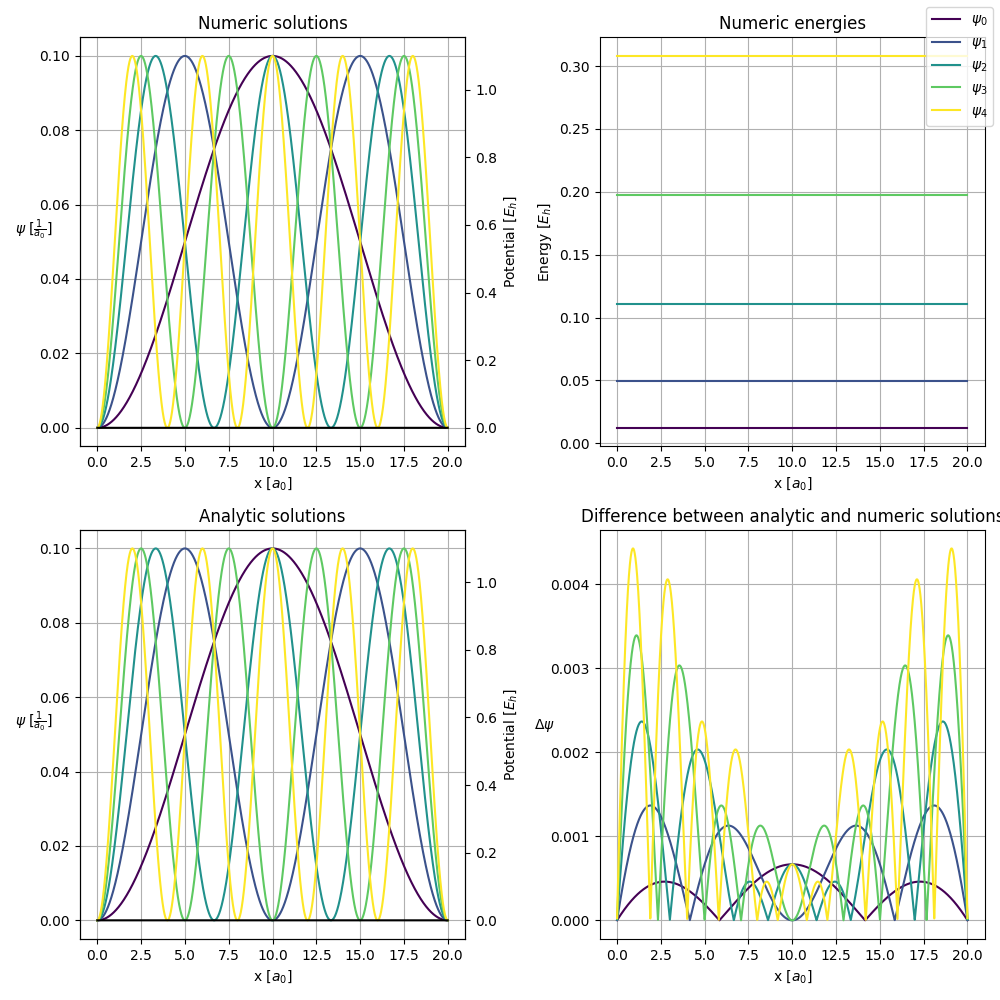

In [6]:
def V_0(x: np.ndarray) -> np.ndarray:  # function returns potential, as calculated by the given formula
    return np.zeros_like(x)


# Defining constants
L: float = 20. * a0  # Length of box
N: int = 3000  # number of points on the x axis
m: float = me  # mass of particle
x: np.ndarray = np.linspace(0, L, N)  # x-values
num: int = 20  # number of calculated analytic wave functions / energies


# analytical calculation of wave functions and energies
wave_anal: np.ndarray = np.zeros((num, x.size))
for n in range(1, num+1):
    wave_anal[n-1] = np.sqrt(2/L) * np.sin(n * np.pi * x / L)
E_anal: np.ndarray = np.arange(1, num+1)**2 * np.pi**2 * hb**2 / (2 * m * L**2)


# defining the given potential and numerical calculation of wave functions and energies
V: np.ndarray = V_0(x)
E, waves = stationary_states(V, x, m=m)


# visualization of results
plot(V, x, E, waves, E_anal, wave_anal, absolute_square=True, atomic_units=atomic_units)


We see that the numerical solution, and the analytical solution of the wave function are both sine solutions. This is as expected. It is also as expected that the wave function has an increasing number of zero points for increasing excited state. We see that the ground state $\psi_0$ has none, while $\psi_1$ has one, and so on. We also observe that every other solution is symmetrical and antisymmetric, as expected, because of sine odd nature. $\psi_0$ is symmetrical, $\psi_1$ is antisymmetric, and so on. We also see that for all practical purposes, the numerical and analytical solution are almost identical. 

For the energy levels, we observe the presence of $n^2$ in the analytical expression for the energy. Therefore, the space between the energy levels increases as the square of n. The larger n, the larger the distance between the energy levels. 

## Harmonisk oscillator

Et annet standard kvantemekanisk problem er den harmoniske oscillatoren med
$$
V(x) = \frac{1}{2}m \omega^2 x^2,
\quad \psi(x) = \frac{1}{\sqrt{2^n n!}} \cdot \left(\frac{m \omega}{\pi \hbar}\right)^{1/4} \cdot \exp{\left(-\frac{m \omega x^2}{2 \hbar}\right)} \cdot H_n\left(\sqrt{\frac{m \omega}{\hbar}}x\right),
\quad E = \left(n+\frac{1}{2}\right)\hbar \omega,
\quad \quad n = 0, 1, 2, \ldots
$$
Funksjonene $H_n(y)$ (med dimensjonsløs $y$) kalles [(fysikerens) Hermitepolynomer](https://en.wikipedia.org/wiki/Hermite_polynomials).
De er tilgjengelige i numerikkbiblioteker, men kan også beregnes fra rekursjonsrelasjonen
$$ H_n(x) = 2 x H_{n-1}(x) - 2 (n-1) H_{n-2}(x), \quad H_0(x) = 1, \quad H_1(x) = 2 x$$

Den harmoniske oscillatoren er spesielt interessant i topartikkelsystemer, der et problem med for eksempel to atomer med masse $m_1$ og $m_2$ i et toatomig molekyl reduseres til et ekvivalent enpartikkelproblem med *redusert masse* $m = m_1 m_2 / (m_1 + m_2)$.
Sammen med konstanten $\omega$ utgjør denne et mål på en fjærkonstant som beskriver vibrasjonsbevegelsen mellom de to atomene.

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner i en harmonisk oscillator grafisk.**

**Hvordan er spredningen i energinivåene?**

<IPython.core.display.Javascript object>


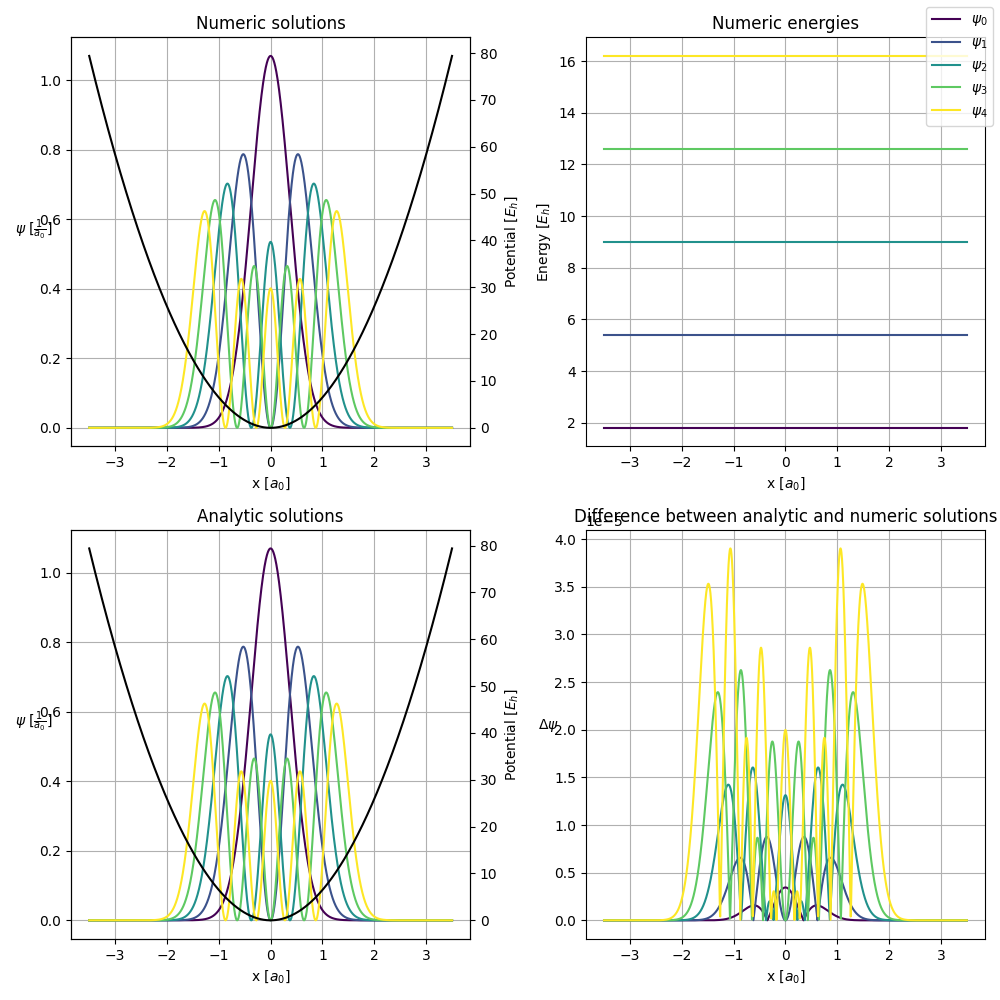

In [7]:
def V_harmonic(x: np.ndarray, m: float, w: float) -> np.ndarray:  # defines harmonic potential, given formula
    return 0.5 * m * w**2 * x**2


def hermite(_x: np.ndarray, n: int, computed: Optional[dict] = None):  # defines a function that calculates the n'th 
                                                                       # hermite polynomial
    if computed is None:
        computed = {0: 1., 1: 2*_x}
    if n in computed:
        return computed[n]
    ans: np.ndarray = 2*_x * hermite(_x, n-1, computed) - 2*(n-1) * hermite(_x, n-2, computed)
    computed[n] = ans
    return ans


# Defining constants
L: float = 3.5 * a0  # Length of interval
N: int = 2000  # number of points on the x axis
m: float = me  # mass of particle
w: float = 3.6 * Eh/hb
x: np.ndarray = np.linspace(-L, L, N)  # x-values
num: int = 20  # number of calculated analytic wave functions/energies


# analytical calculation of wave functions and energies
wave_anal: np.ndarray = np.zeros((num, x.size))
hermite_computed: dict = {0: 1., 1: 2*x*np.sqrt(m*w/hb)}  # Used for memoization in the recursive definition of the hermite polynomials
for n in range(num):
    alpha: float = 1/(np.sqrt(float(2**n * np.math.factorial(n))))
    beta: float = (m * w/(np.pi * hb))**0.25
    gamma: np.ndarray = np.exp(-m * w * x**2/(2*hb))
    wave_anal[n] = alpha * beta * gamma * hermite(x*np.sqrt(m*w/hb), n, hermite_computed)
E_anal: np.ndarray = (np.arange(0, num) + 0.5) * hb * w


# defining the given potential and numerical calculation of wave functions and energies
V_1: np.ndarray = V_harmonic(x, m, w)
E, waves = stationary_states(V_1, x, m=m)


# visualization of results
plot(V_1, x, E, waves, E_anal, wave_anal, absolute_square=True, atomic_units=atomic_units)


The observations for the wave function are similar to those in the previous situation. The numerical and analytic solutions fit well together, with error in the magnitude $10^{-5}$. We observe corresponding symmetry and zero points as before. 

As observed by the analytical expression of energy, we have only n dependence here. Therefore, there is an equal distance between all energy levels. 

## Partikkel i endelige brønnpotensialer

Et tredje velkjent eksempel er enkeltbrønnen
$$V(x) = \begin{cases}
-V_0 & \text{for}\,\, 0 < x < w \\ 
0   & \text{ellers}
\end{cases}$$
med bredde $w$ og brønndybde $V_0 > 0$.
I dette potensialet finnes ingen analytiske løsninger for de bundne stasjonære tilstandenes energiegenverdier.

Enkeltbrønnen kan generaliseres til et potensial bestående av $N_w$ slike enkeltbrønner plassert ved siden av hverandre med en fast avstand $g$ mellom hver brønn.
Med første brønn i $x = 0$, kan vi uttrykke det sammensatte brønnpotensialet stykkevis som

$$V(x) = \begin{cases}
0    & \text{for}\,\, x < 0 \,\, \text{og} \,\, x > N_w (w + g) & \text{(utenfor brønnområdet)} \\
-V_0 & \text{for}\,\, \frac{x}{w+g} - \left\lfloor \frac{x}{w+g} \right\rfloor < \frac{w}{w+g} & \text{(i brønnene)} \\
0    & \text{ellers} & \text{(mellom brønnene)} \\
\end{cases}$$

Dette er en enkel modell for det periodiske potensialet som et elektron opplever i et fast stoff med en regulær krystallinsk struktur, for eksempel et metall.

**Framstill de bundne tilstandene for et elektron både i en enkeltbrønn og i et sammensatt potensial bestående av mange brønner grafisk. Legg inn et passe stort område med $V = 0$ på begge sider av brønnområdet.**

**Hvordan distribueres energinivåene i potensialet bestående av mange brønner sammenlignet med enkeltbrønnen? Kan du ut fra dette forklare hva vi mener med *energibåndstrukturen* til et fast stoff ved hjelp av begrepene *båndbredde* og *båndgap*?**

<IPython.core.display.Javascript object>


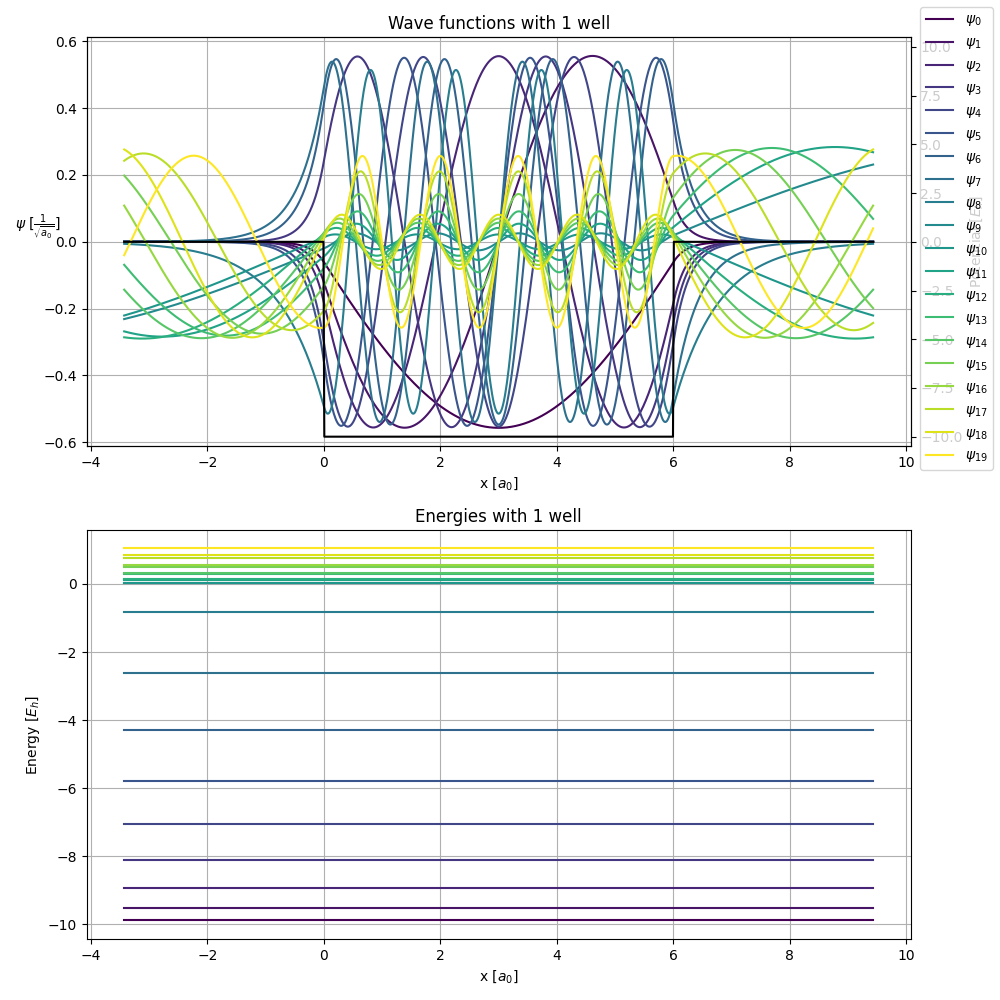

<IPython.core.display.Javascript object>


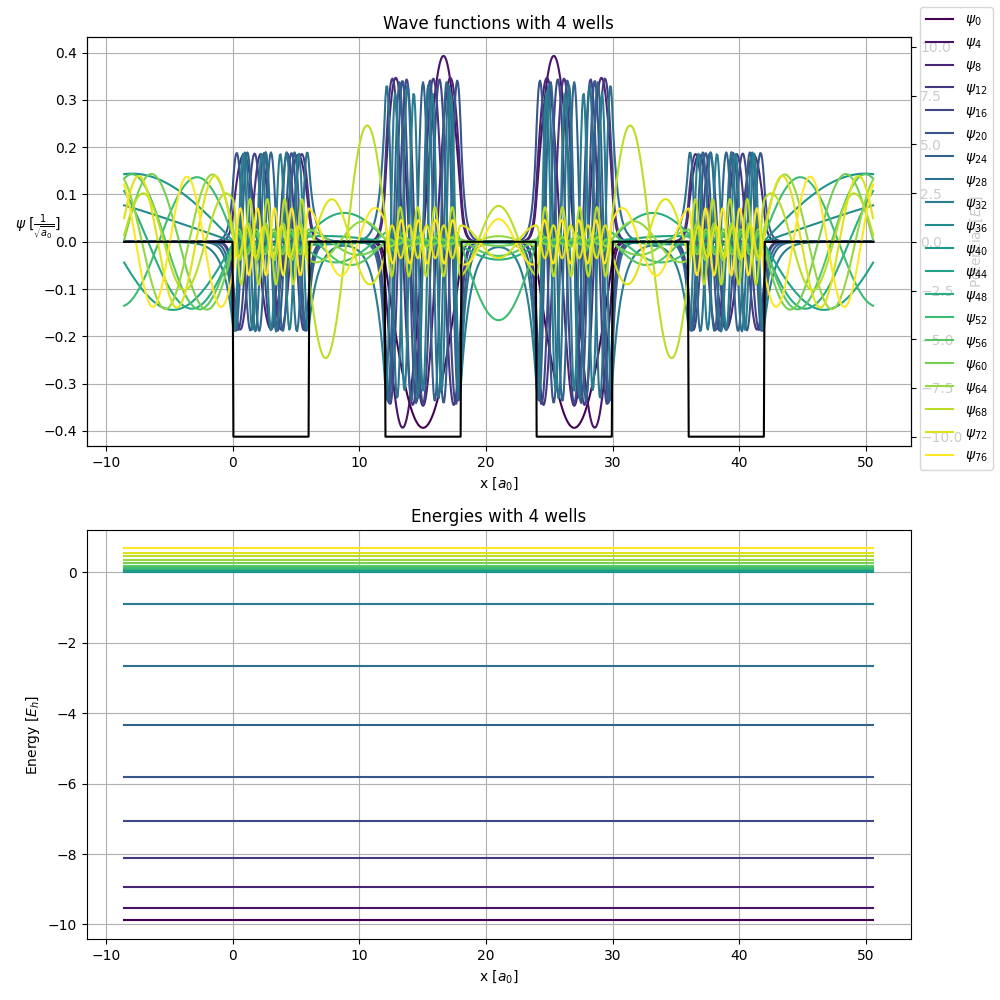

<IPython.core.display.Javascript object>


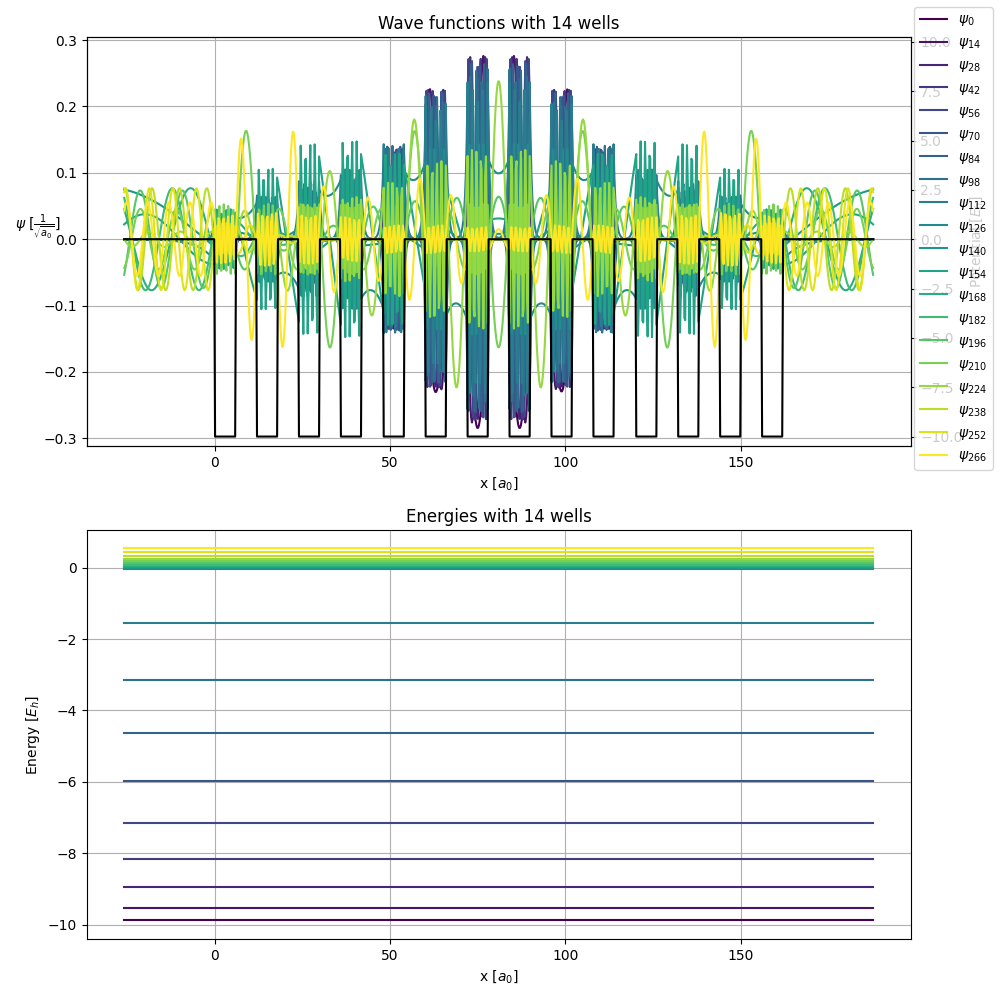

In [8]:
def make_padded_x_arr(Nw: int, w: float, g: float, N: int) -> np.ndarray:  # returns 1D-array of x-values, which is used to 
                                                                           # calculate/make potential wells. 
    extra_area: float = 1. * Nw * (w + g)  # Space with potential = 0 of both sides
    return np.linspace(-extra_area, w + (Nw-1)*(w+g) + extra_area, N)


def V_wells(x: np.ndarray, V0: float, w: float, g: float, Nw: int) -> np.ndarray:  # returns 1D-array with calculated potential
    V: np.ndarray = np.zeros_like(x)
    V[x/(w+g) - np.floor(x/(w+g)) < w/(w+g)] = -V0
    V[x < 0] = V[x > (Nw-1)*(w+g)+w] = 0.
    return V


# Defining constants
Nw_list: list = [1, 4, 14]  # Number of wells
    
for Nw in Nw_list:
    w: float = 6. * a0  # Well width
    g: float = 6. * a0  # Distance between wells
    N: int = 2000  # Number of x-vals
    V0: float = 10. * Eh
    m: float = me


    # initializing arrays
    x: np.ndarray = make_padded_x_arr(Nw=Nw, w=w, g=g, N=N)
    V_2: np.ndarray = V_wells(x, V0=V0, w=w, g=g, Nw=Nw)


    # defining the given potential and numerical calculation of wave functions and energies
    E, waves = stationary_states(V_2, x, m=m)

    # cutting off irrelevant 0-information on both sides
    start = int(x.size/3.5)
    end = x.size - start
    x = x[start:end]
    waves = waves[:, start:end]
    V_2 = V_2[start:end]


    # visualization of results
    plural = "s"
    if Nw == 1:
        plural = ""
    plot(V_2, x, E, waves, num_plots=20, jump_plots=Nw, atomic_units=atomic_units, 
         numeric_title=f"Wave functions with {Nw} well"+plural, energy_title=f"Energies with {Nw} well"+plural)

The interesting observation here is the difference between positive and negative energy levels. We observe that the steady states with positive energy are not confined to the wells, as they are classically allowed outside the wells

Please note that the edges of these plots do $\underline{not}$ represent infinite potentials, there is a longer stretch not shown here with 0 potential outside the plots

<IPython.core.display.Javascript object>


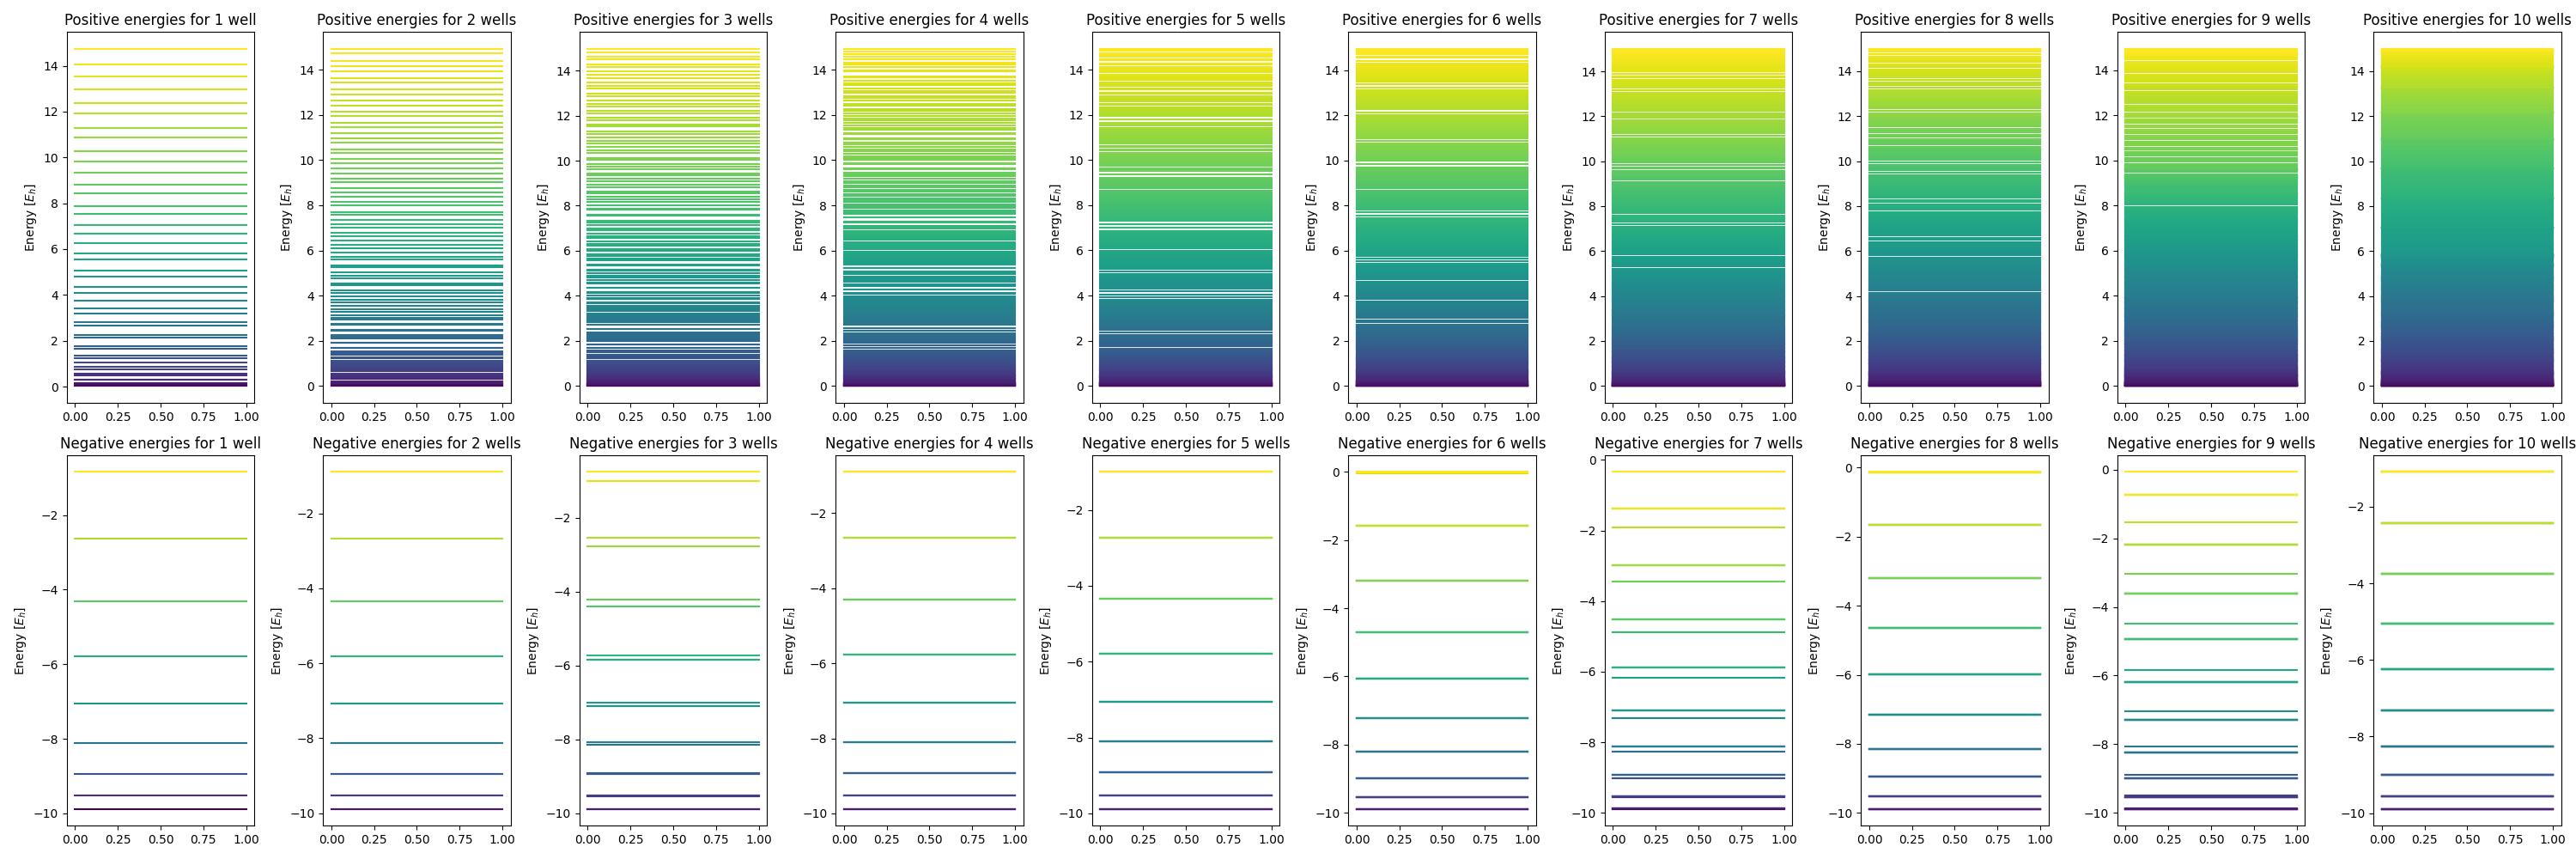

In [9]:
w: float = 6. * a0  # Well width
g: float = 6. * a0  # Distance between wells
N: int = 1000  # Number of x-vals
V0: float = 10. * Eh
m: float = me

    
# Looking at how the energies change depending on the number of wells
num = 10
fig = plt.figure(figsize=(3*num, 10))
for n in range(1, num+1):
    Nw = n
    # initializing arrays
    x: np.ndarray = make_padded_x_arr(Nw=Nw, w=w, g=g, N=N)
    V_n: np.ndarray = V_wells(x, V0=V0, w=w, g=g, Nw=Nw)
    
    # defining the given potential and numerical calculation of wave functions and energies
    E, waves = stationary_states(V_n, x, m=m)

    
    E_unit: str = "E_h" if atomic_units else "J"
    plural = "s"
    if n == 1:
        plural = ""
        
    ax_pos = fig.add_subplot(2, num, n)
    ax_neg = fig.add_subplot(2, num, n+num)
    
    # plot the negative energies
    neg_count = np.argmax(E >= 0)  # argmax returns the index of the first non-negative value
    ax_neg.set_prop_cycle(plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, neg_count))))
    
    ax_neg.set_title(f"Negative energies for {n} well"+plural)
    ax_neg.set_ylabel("Energy $["+E_unit+"]$")
    
    for i in range(neg_count):
        ax_neg.plot([0, 1], [E[i], E[i]])
       
    
    # plot some positive energies
    pos_count = np.argmax(E > 15) - neg_count
    ax_pos.set_prop_cycle(plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, pos_count))))
    
    ax_pos.set_title(f"Positive energies for {n} well"+plural)
    ax_pos.set_ylabel("Energy $["+E_unit+"]$")
    
    for i in range(pos_count):
        ax_pos.plot([0, 1], [E[i+neg_count], E[i+neg_count]])
    

fig.tight_layout()
plt.show()

The interesting observation here applies to energy. For the steady states with negative energy (ie. "trapped" in the wells), we observe that the allowed energy levels are the same, regardless of the number of wells.

For the steady states with positive energy (ie. classically allowed outside the wells), we observe that the energy levels are almost continuous. They are, of course, discretized, as a result of the numerical solution. But what we see is that the free particles can have any energy.